# New Zealand Time-series Forecasting Model

# Pre-processing and Modeling 

In this notebook we are going to do pre-processing and modeling on our time-series data. We are going to decide what we want to focus on with this modeling. 

We'll start with the tourism arrivals data and then look at the accomodation data. 

We will beging by importing the necessary packages for looking at the data and creating our models.

[1.0 Tourism Data](#1.0-Tourism-Data)

[2.0 Accomodation Data](#2.0-Accomodation-Data)

In [20]:
# Import data processing packages
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.metrics import mean_squared_error

#Time Series Packages
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

#Time Series Modeling Packages
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Modeling packages
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import datetime as dt

#Visualization 
import matplotlib. pyplot as plt
import seaborn as sns

# 1.0 Tourism Data
For our `arrivals` data we are going to look at the following regions as these have the most complete time-series data:
> - Auckland
> - Christchurch
> - Wellington
> - Queenstown
> - All New Zealand Ports
    
For each of these regions, we are going to look at the following reasons for travel:
> - Business
> - Holiday
> - Visiting Friends
> - Total Travel

We want to create the most complete picture that we can for our forecasting and making sure we work on creating as thorough of a forecasting as we can. 

In [2]:
## Load our Tourism Data
# Remove extra white space at end of column

arrivals = pd.read_csv('../NZ Data/Arrivals Data Cleaned.csv', skipinitialspace = True, parse_dates = True, \
                       index_col = 0)
arrivals.columns = arrivals.columns.str.replace(r' $','', regex = True)
arrivals.columns

Index(['BusinessAuckland', 'BusinessChristchurch', 'BusinessDunedin',
       'BusinessHamilton', 'BusinessPalmerston North', 'BusinessRotorua',
       'BusinessWellington', 'BusinessQueenstown',
       'BusinessTOTAL NEW ZEALAND PORTS', 'Holiday/VacationAuckland',
       'Holiday/VacationChristchurch', 'Holiday/VacationDunedin',
       'Holiday/VacationHamilton', 'Holiday/VacationPalmerston North',
       'Holiday/VacationRotorua', 'Holiday/VacationWellington',
       'Holiday/VacationQueenstown', 'Holiday/VacationTOTAL NEW ZEALAND PORTS',
       'Visit Friends/RelativesAuckland',
       'Visit Friends/RelativesChristchurch', 'Visit Friends/RelativesDunedin',
       'Visit Friends/RelativesHamilton',
       'Visit Friends/RelativesPalmerston North',
       'Visit Friends/RelativesRotorua', 'Visit Friends/RelativesWellington',
       'Visit Friends/RelativesQueenstown',
       'Visit Friends/RelativesTOTAL NEW ZEALAND PORTS',
       'TOTAL ALL TRAVEL PURPOSESAuckland',
       'TOTAL ALL

In [5]:
# Check to make sure index is datetime
arrivals.index

DatetimeIndex(['1978-04-01', '1978-05-01', '1978-06-01', '1978-07-01',
               '1978-08-01', '1978-09-01', '1978-10-01', '1978-11-01',
               '1978-12-01', '1979-01-01',
               ...
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01'],
              dtype='datetime64[ns]', name='Date', length=530, freq=None)

In [6]:
arrivals.head()

,BusinessAuckland,BusinessChristchurch,BusinessDunedin,BusinessHamilton,BusinessPalmerston North,BusinessRotorua,BusinessWellington,BusinessQueenstown,BusinessTOTAL NEW ZEALAND PORTS,Holiday/VacationAuckland,...,Visit Friends/RelativesTOTAL NEW ZEALAND PORTS,TOTAL ALL TRAVEL PURPOSESAuckland,TOTAL ALL TRAVEL PURPOSESChristchurch,TOTAL ALL TRAVEL PURPOSESDunedin,TOTAL ALL TRAVEL PURPOSESHamilton,TOTAL ALL TRAVEL PURPOSESPalmerston North,TOTAL ALL TRAVEL PURPOSESRotorua,TOTAL ALL TRAVEL PURPOSESWellington,TOTAL ALL TRAVEL PURPOSESQueenstown,TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS
Date,,,,,,,,,,,,,,,,,,,,,
1978-04-01,3428.0,468.0,0.0,0.0,0.0,0.0,492.0,0.0,4408.0,10476.0,...,3324.0,19856.0,6240.0,0.0,0.0,0.0,0.0,2116.0,0.0,28524.0
1978-05-01,2264.0,524.0,0.0,0.0,0.0,0.0,428.0,0.0,3236.0,7168.0,...,3568.0,15428.0,5240.0,0.0,0.0,0.0,0.0,2156.0,0.0,23060.0
1978-06-01,2136.0,280.0,0.0,0.0,0.0,0.0,384.0,0.0,2880.0,4640.0,...,2600.0,11416.0,2708.0,0.0,0.0,0.0,0.0,1252.0,0.0,15760.0
1978-07-01,2156.0,324.0,0.0,0.0,0.0,0.0,380.0,0.0,2964.0,6184.0,...,3144.0,14072.0,4900.0,0.0,0.0,0.0,0.0,1480.0,0.0,20892.0
1978-08-01,2304.0,536.0,0.0,0.0,0.0,0.0,496.0,0.0,3416.0,8236.0,...,4204.0,17960.0,7900.0,0.0,0.0,0.0,0.0,2748.0,0.0,28992.0


In [16]:
# Load our model results from the pycaret notebook to look at which models might work best for us
potential_models = pd.read_csv('../NZ Data/arrivals_model_results.csv',index_col = 0)
potential_models.head()

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2,TT (Sec),time_series
exp_smooth,Exponential Smoothing,1847.4689,3039.9658,8.729000e+00,0.1226,2.1200,2.6891,0.5611,0.0633,BusinessAuckland
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,292.8787,448.0243,1.620000e+17,0.1555,1.2487,1.4706,0.4044,0.0200,BusinessChristchurch
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,23.9385,29.7550,2.360000e+16,0.5721,1.2396,0.8072,-0.4410,0.0200,BusinessDunedin
naive,Naive Forecaster,0.5139,2.4227,5.560000e-02,0.1111,0.0278,0.0721,-0.0580,0.0067,BusinessHamilton
naive,Naive Forecaster,0.0000,0.0000,0.000000e+00,0.0000,0.0000,0.0000,1.0000,0.0067,BusinessPalmerston North


We have here the list of all of our models that we tested using the pycaret model. As discussed in our previous notebook, we are not interested in actually modeling out all of these trends due to issues with the data or lack of historic data. We'll start with looking at our Arrivals dataset.

We will be forecasting the following datasets from the Arrivals dataset:
- TOTAL ALL TRAVEL PURPOSESAuckland
- TOTAL ALL TRAVEL PURPOSESChristchurch
- TOTAL ALL TRAVEL PURPOSESWellington
- TOTAL ALL TRAVEL PURPOSESQueenstown
- TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS
- BusinessAuckland
- BusinessChristchurch
- BusinessWellington
- BusinessQueenstown
- BusinessTOTAL NEW ZEALAND PORTS
- Holiday/VacationAuckland
- Holiday/VacationChristchurch
- Holiday/VacationWellington
- Holiday/VacationQueenstown
- Holiday/VacationTOTAL NEW ZEALAND PORTS

This is capture a wide breadth of models without overwhelming ourselves. Thus to make our above model results table more readable, we will subset and look at only the subset we are interested in.

In [13]:
# Creating list of subset
arrivals_model_list = ['TOTAL ALL TRAVEL PURPOSESAuckland', 'TOTAL ALL TRAVEL PURPOSESChristchurch', \
                       'TOTAL ALL TRAVEL PURPOSESWellington', 'TOTAL ALL TRAVEL PURPOSESQueenstown',\
                      'TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS',\
                      'BusinessAuckland','BusinessChristchurch','BusinessWellington', 'BusinessQueenstown',\
                      'BusinessTOTAL NEW ZEALAND PORTS',\
                      'Holiday/VacationAuckland','Holiday/VacationChristchurch', 'Holiday/VacationWellington',\
                      'Holiday/VacationQueenstown','Holiday/VacationTOTAL NEW ZEALAND PORTS']

In [17]:
arrivals_model_sub = potential_models[potential_models['time_series'].isin(arrivals_model_list)]
arrivals_model_sub

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2,TT (Sec),time_series
exp_smooth,Exponential Smoothing,1847.4689,3039.9658,8.729000e+00,0.1226,2.1200,2.6891,0.5611,0.0633,BusinessAuckland
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,292.8787,448.0243,1.620000e+17,0.1555,1.2487,1.4706,0.4044,0.0200,BusinessChristchurch
exp_smooth,Exponential Smoothing,327.1570,525.1005,1.770000e+17,0.1483,1.4471,1.7904,0.4470,0.0400,BusinessWellington
ets,ETS,119.2602,168.2450,8.940000e+16,0.2367,3.7151,2.4567,0.2016,0.0300,BusinessQueenstown
exp_smooth,Exponential Smoothing,2357.5204,3906.6538,9.945200e+00,0.1204,2.1446,2.6790,0.5671,0.0400,BusinessTOTAL NEW ZEALAND PORTS
exp_smooth,Exponential Smoothing,12095.1677,19280.2792,5.368139e+02,0.1542,2.8119,3.0626,0.7525,0.0433,Holiday/VacationAuckland
arima,ARIMA,3625.2503,5694.6243,1.040000e+18,0.1666,1.7507,1.9920,0.7231,0.0400,Holiday/VacationChristchurch
ets,ETS,675.4736,984.8224,4.990000e+17,0.1873,1.7479,1.4985,0.6799,0.0533,Holiday/VacationWellington
ets,ETS,1807.8334,2922.2106,2.020000e+18,0.1426,4.3983,3.0722,0.8024,0.1133,Holiday/VacationQueenstown
bats,BATS,17376.7746,27582.7614,5.915086e+02,0.1480,2.8512,3.1626,0.7463,9.9567,Holiday/VacationTOTAL NEW ZEALAND PORTS


## Modeling Business Time Series

In this section we will model out our business model time series and analyze those results

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

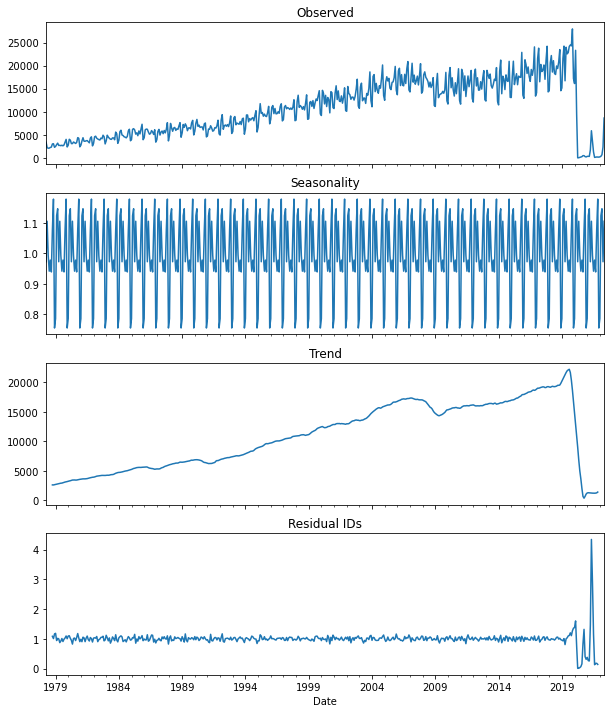

In [23]:
# Start with BusinessAuckland, we will use ExponentialSmoothing to model 
# First lets look at the data and understand its seasonality and ACF/PACF

y = arrivals['BusinessAuckland']

res = seasonal_decompose(y, model='mult')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

In [43]:
# Since we have opted to use exponential smoothing, we are not required to take the first difference
# Exponential smoothing can handle trend data 
# The statsmodel implementation of Exponentail Smoothing also optimizes its hyperparamters

exp = ExponentialSmoothing(y, trend = 'mul', seasonal = 'mul', seasonal_periods = 12, damped_trend = True)

C:\Users\lutimoth\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\lutimoth\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [80]:
exp_fit = exp.fit(method = 'bh')
exp_fit.summary()

Dep. Variable:,BusinessTOTAL NEW ZEALAND PORTS,No. Observations:,530
Model:,ExponentialSmoothing,SSE,1338457421.283
Optimized:,True,AIC,7847.210
Trend:,Multiplicative,BIC,7919.849
Seasonal:,Multiplicative,AICC,7848.701
Seasonal Periods:,12,Date:,"Tue, 26 Jul 2022"
Box-Cox:,False,Time:,23:17:38
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7995613,alpha,True
smoothing_trend,0.000000,beta,True


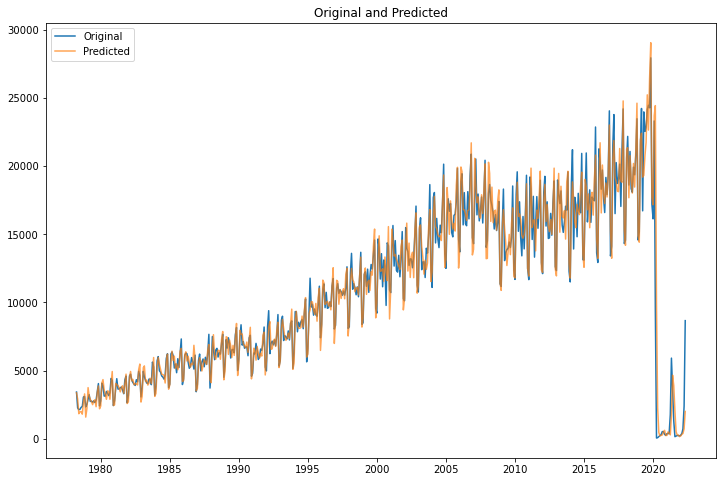

In [45]:
plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [46]:
y_fore = exp_fit.forecast(36)

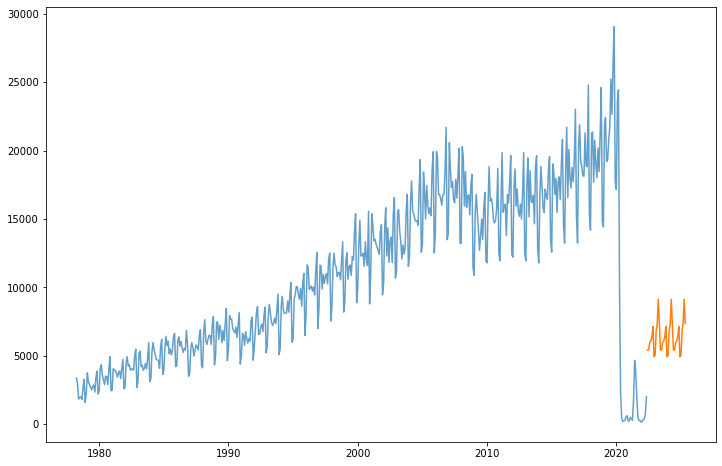

In [47]:
plt.figure(figsize=(12,8))

plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

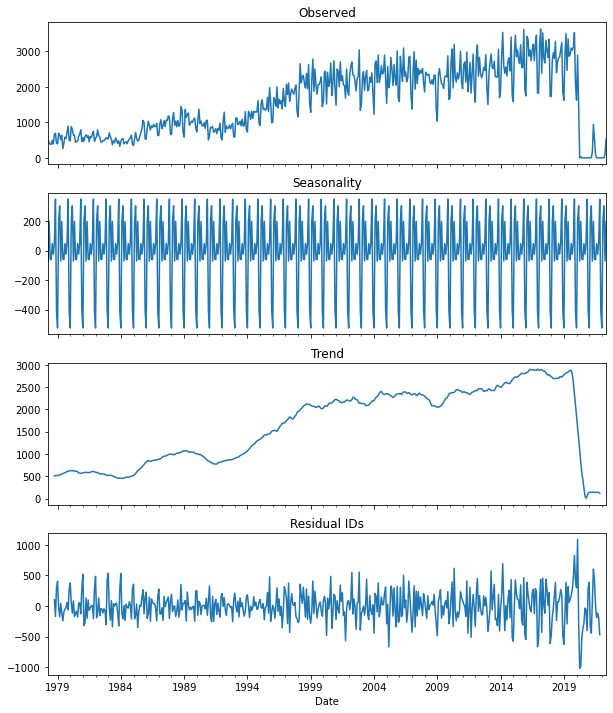

In [49]:
# Business Wellington
y = arrivals['BusinessWellington']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

C:\Users\lutimoth\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\lutimoth\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


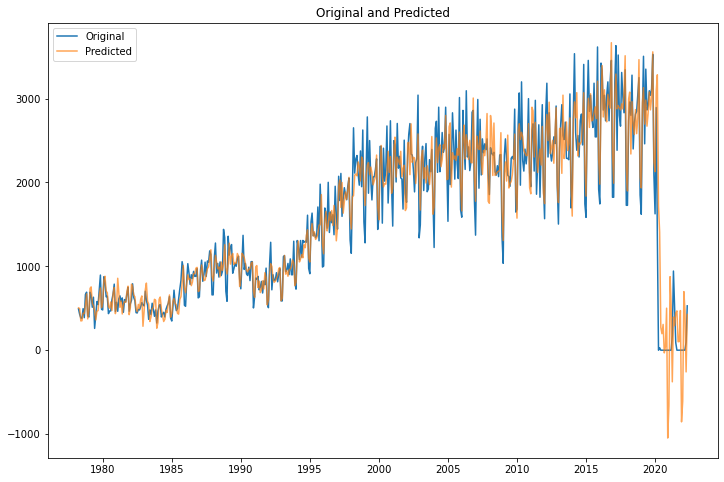

In [52]:
exp = ExponentialSmoothing(y, trend = 'add', seasonal = 'add', seasonal_periods = 12, damped_trend = True)
exp_fit = exp.fit(method = 'bh')

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [79]:
exp_fit.summary()

Dep. Variable:,BusinessTOTAL NEW ZEALAND PORTS,No. Observations:,530
Model:,ExponentialSmoothing,SSE,1339205741.771
Optimized:,True,AIC,7847.507
Trend:,Multiplicative,BIC,7920.146
Seasonal:,Multiplicative,AICC,7848.997
Seasonal Periods:,12,Date:,"Tue, 26 Jul 2022"
Box-Cox:,False,Time:,23:17:16
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8000947,alpha,True
smoothing_trend,4.3606e-34,beta,True


C:\Users\lutimoth\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


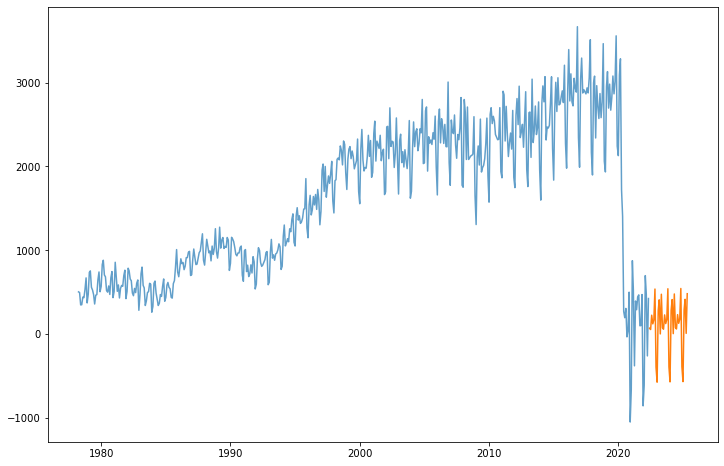

In [53]:
y_fore = exp_fit.forecast(36)
plt.figure(figsize=(12,8))

plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

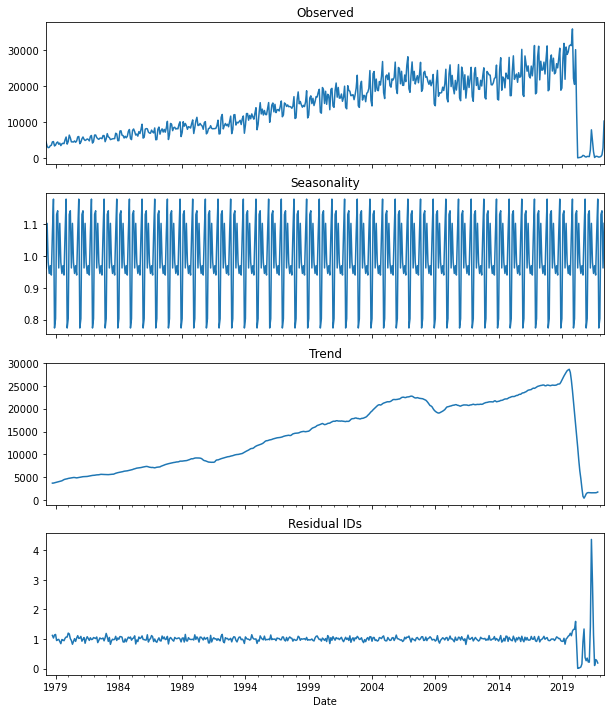

In [55]:
#All BUsiness NZ
y = arrivals['BusinessTOTAL NEW ZEALAND PORTS']

res = seasonal_decompose(y, model='mul')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

C:\Users\lutimoth\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\lutimoth\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


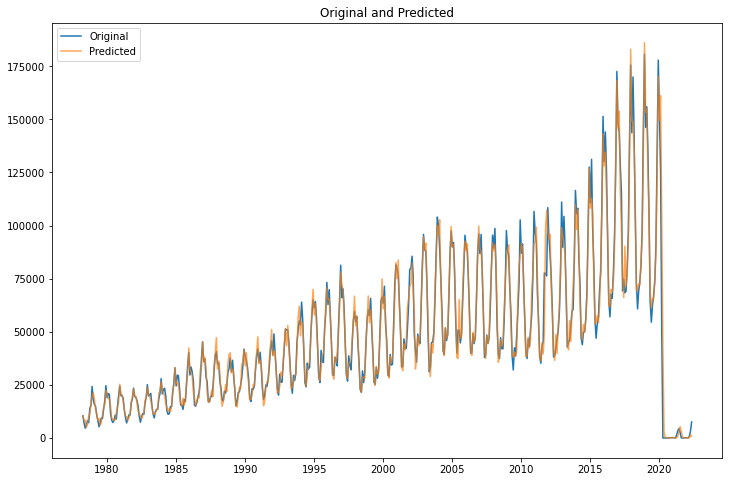

In [102]:
exp = ExponentialSmoothing(y, trend = 'mul', seasonal = 'mul', seasonal_periods = 12, damped_trend = True)
exp_fit = exp.fit(method = 'ls')

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [103]:
exp_fit.summary()

Dep. Variable:,Holiday/VacationAuckland,No. Observations:,530
Model:,ExponentialSmoothing,SSE,18702721396.819
Optimized:,True,AIC,9244.901
Trend:,Multiplicative,BIC,9317.540
Seasonal:,Multiplicative,AICC,9246.391
Seasonal Periods:,12,Date:,"Tue, 26 Jul 2022"
Box-Cox:,False,Time:,23:29:56
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8937471,alpha,True
smoothing_trend,1.2295e-38,beta,True


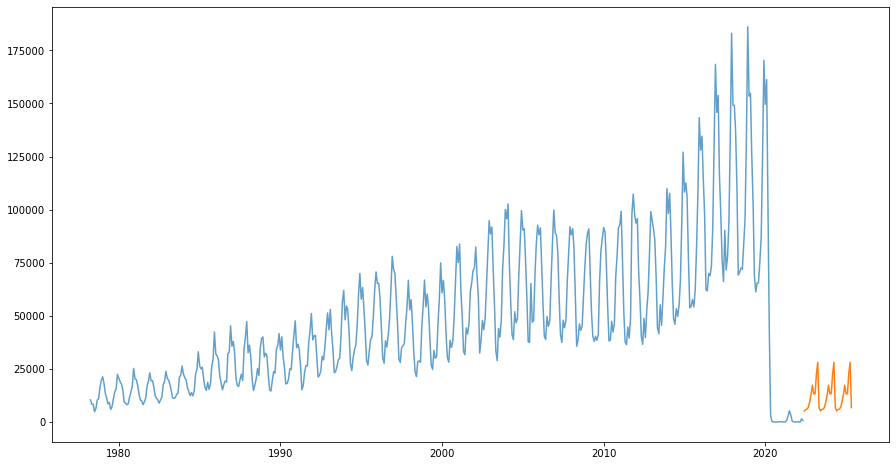

In [104]:
y_fore = exp_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

In [ ]:
#BUSINESS CHRISTCHURCH

In [ ]:
#BUSINESS Queenstown

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

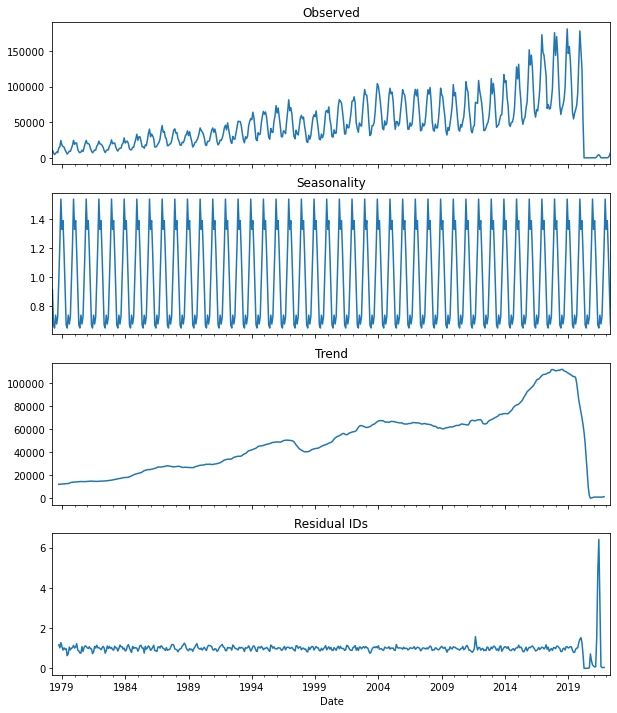

In [81]:
#Holiday/VacationAuckland Exp Smoothing
y = arrivals['Holiday/VacationAuckland']

res = seasonal_decompose(y, model='mul')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

C:\Users\lutimoth\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


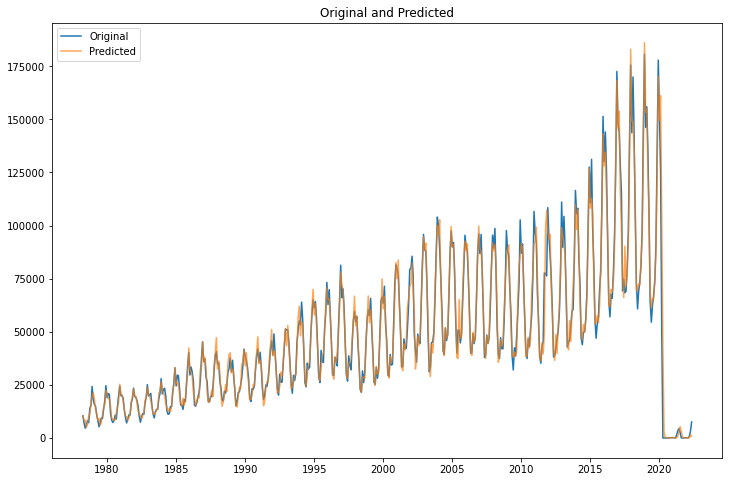

In [105]:
exp = ExponentialSmoothing(y, trend = 'mul', seasonal = 'mul', damped_trend = True)
exp_fit = exp.fit(method = 'ls')

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [106]:
exp_fit.summary()

Dep. Variable:,Holiday/VacationAuckland,No. Observations:,530
Model:,ExponentialSmoothing,SSE,18702721396.819
Optimized:,True,AIC,9244.901
Trend:,Multiplicative,BIC,9317.540
Seasonal:,Multiplicative,AICC,9246.391
Seasonal Periods:,12,Date:,"Tue, 26 Jul 2022"
Box-Cox:,False,Time:,23:30:29
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8937471,alpha,True
smoothing_trend,1.2295e-38,beta,True


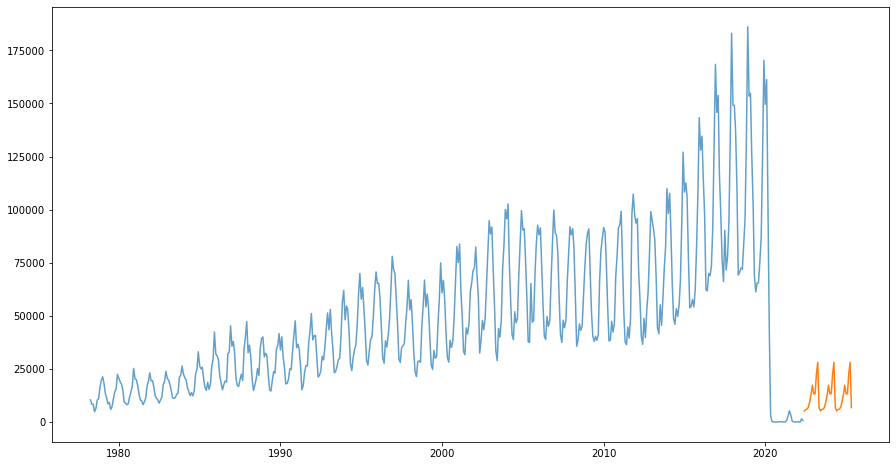

In [107]:
y_fore = exp_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

In [ ]:
#Holiday/VacationChristchurch

In [ ]:
#Holiday/VacationWellington

In [ ]:
#Holiday/VacationQueenstown

In [ ]:
#Holiday/VacationTOTAL NEW ZEALAND PORT

In [ ]:
#TOTAL ALL TRAVEL PURPOSESAuckland

In [ ]:
#TOTAL ALL TRAVEL PURPOSESChristchurch

In [ ]:
#TOTAL ALL TRAVEL PURPOSESWellington

In [ ]:
#TOTAL ALL TRAVEL PURPOSESQueenstown

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

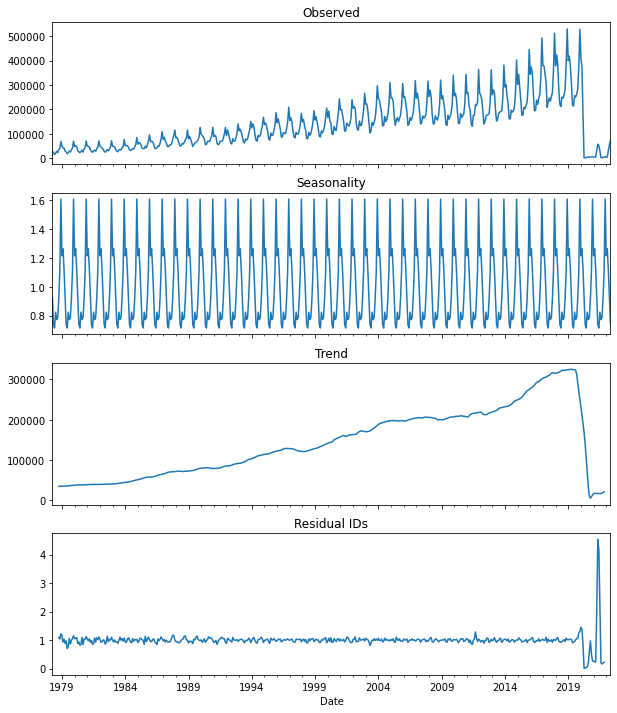

In [108]:
#TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS
y = arrivals['TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS']

res = seasonal_decompose(y, model='mul')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

C:\Users\lutimoth\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\lutimoth\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


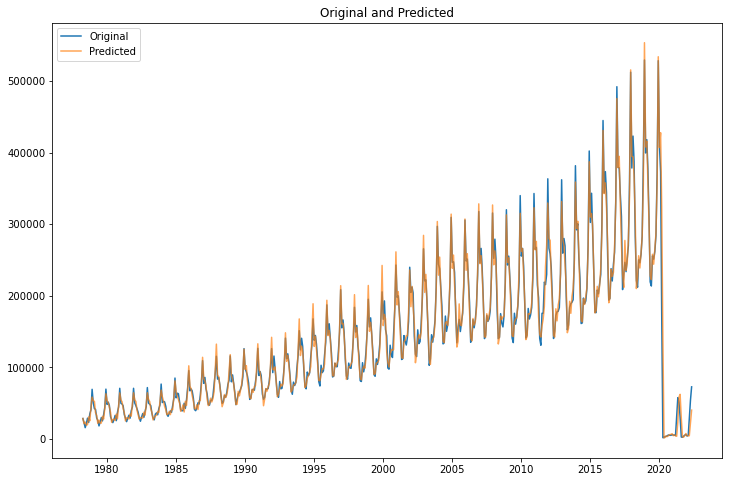

In [109]:
exp = ExponentialSmoothing(y, trend = 'mul', seasonal = 'mul', damped_trend = True)
exp_fit = exp.fit(method = 'ls')

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [110]:
exp_fit.summary()

Dep. Variable:,TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS,No. Observations:,530
Model:,ExponentialSmoothing,SSE,99310448976.597
Optimized:,True,AIC,10129.779
Trend:,Multiplicative,BIC,10202.418
Seasonal:,Multiplicative,AICC,10131.269
Seasonal Periods:,12,Date:,"Tue, 26 Jul 2022"
Box-Cox:,False,Time:,23:35:13
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,6.5322e-36,beta,True


In [ ]:
y_fore = exp_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

# 2.0 Accomodation-Data